In [17]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# Read the CSV files
cal_df = pd.read_csv('data/raw/calendar2024.csv')
lis_df = pd.read_csv('data/raw/listings2024.csv') 
rev_df = pd.read_csv('data/raw/reviews2024.csv')

## Initial EDA

In [19]:
lis_df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,31094,https://www.airbnb.com/rooms/31094,20240629155650,2024-06-30,previous scrape,"Beautiful, spacious, central, renovated Penthouse","Welcome to our home, we hope you will enjoy Wo...","What else is nearby?<br />To be honest, We thi...",https://a0.muscache.com/pictures/miso/Hosting-...,129976,...,4.82,4.80,4.53,NaN,f,1,1,0,0,0.11
1,262961,https://www.airbnb.com/rooms/262961,20240629155650,2024-06-30,city scrape,192m2 FLAT+ 8m2 BALCONY IN CENTER NØRREBRO HOOD,If you are looking for a large apartment in ce...,TIME OUT - The world’s coolest neighbourhoods ...,https://a0.muscache.com/pictures/261aa506-7b13...,1379904,...,4.94,4.89,4.53,NaN,f,1,1,0,0,0.24
2,263036,https://www.airbnb.com/rooms/263036,20240629155650,2024-06-30,city scrape,Bright flat in central location,NaN,NaN,https://a0.muscache.com/pictures/17770169/f1fb...,1232471,...,4.86,4.81,4.67,NaN,f,1,1,0,0,0.14
3,32379,https://www.airbnb.com/rooms/32379,20240629155650,2024-06-30,city scrape,"155 m2 artist flat on Vesterbro, with 2 bathrooms",You enter a narrow entrance and feel the good ...,"Værnedamsvej area is super hip area, we call i...",https://a0.muscache.com/pictures/miso/Hosting-...,140105,...,4.91,4.89,4.71,NaN,f,2,1,1,0,0.49
4,263708,https://www.airbnb.com/rooms/263708,20240629155650,2024-06-30,city scrape,Urban garden on Vesterbro rooftop,NaN,NaN,https://a0.muscache.com/pictures/8ce36f40-ac59...,1383888,...,5.00,4.67,4.00,NaN,f,1,1,0,0,0.02


In [20]:
cal_df.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,586421,2024-06-30,f,$250.00,NaN,4.0,31.0
1,586421,2024-07-01,f,$250.00,NaN,4.0,31.0
2,586421,2024-07-02,t,$250.00,NaN,4.0,31.0
3,586421,2024-07-03,f,$250.00,NaN,4.0,31.0
4,586421,2024-07-04,f,$250.00,NaN,4.0,31.0


In [21]:
rev_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,31094,79346,2010-08-16,171607,Ben,"We had a great stay. Conveniently located, qui..."
1,31094,166275,2011-01-05,306860,Makita,It was a very good stay. The appartment was re...
2,31094,1452299,2012-06-10,1321058,Pierre,Really enjoyed my time at Ebbe's place. It is...
3,31094,6766430,2013-08-24,2182771,Sussie,"The apartment was very well located, 10-15 min..."
4,31094,6827217,2013-08-26,8025926,Wil,"This is a great flat, very clean with everythi..."


In [22]:
# Initial exploration functions
def explore_dataset(df, name):
    print(f"\n{'='*50}")
    print(f"Dataset: {name}")
    print(f"{'='*50}")
    
    print("\n1. Basic Information:")
    print(f"Shape: {df.shape}")
    
    print("\n2. Data Types:")
    print(df.dtypes)
    
    print("\n3. Missing Values:")
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_info = pd.DataFrame({
        'Missing Values': missing,
        'Percentage': missing_pct
    })
    print(missing_info[missing_info['Missing Values'] > 0])
    
    print("\n4. Sample Data:")
    print(df.head())
    
    return missing_info

In [23]:
listings_missing = explore_dataset(lis_df, 'Listings')


Dataset: Listings

1. Basic Information:
Shape: (20909, 75)

2. Data Types:
id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
source                                           object
                                                 ...   
calculated_host_listings_count                    int64
calculated_host_listings_count_entire_homes       int64
calculated_host_listings_count_private_rooms      int64
calculated_host_listings_count_shared_rooms       int64
reviews_per_month                               float64
Length: 75, dtype: object

3. Missing Values:
                              Missing Values  Percentage
description                              674    3.223492
neighborhood_overview                  11925   57.032857
host_name                                  1    0.004783
host_since                       

In [24]:
calendar_missing = explore_dataset(cal_df, 'Calendar')


Dataset: Calendar

1. Basic Information:
Shape: (7631731, 7)

2. Data Types:
listing_id          int64
date               object
available          object
price              object
adjusted_price    float64
minimum_nights    float64
maximum_nights    float64
dtype: object

3. Missing Values:
                Missing Values  Percentage
adjusted_price         7631731  100.000000
minimum_nights               1    0.000013
maximum_nights               1    0.000013

4. Sample Data:
   listing_id        date available    price  adjusted_price  minimum_nights  \
0      586421  2024-06-30         f  $250.00             NaN             4.0   
1      586421  2024-07-01         f  $250.00             NaN             4.0   
2      586421  2024-07-02         t  $250.00             NaN             4.0   
3      586421  2024-07-03         f  $250.00             NaN             4.0   
4      586421  2024-07-04         f  $250.00             NaN             4.0   

   maximum_nights  
0            31.

In [25]:
reviews_missing = explore_dataset(rev_df, 'Reviews')


Dataset: Reviews

1. Basic Information:
Shape: (366636, 6)

2. Data Types:
listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
dtype: object

3. Missing Values:
          Missing Values  Percentage
comments              17    0.004637

4. Sample Data:
   listing_id       id        date  reviewer_id reviewer_name  \
0       31094    79346  2010-08-16       171607           Ben   
1       31094   166275  2011-01-05       306860        Makita   
2       31094  1452299  2012-06-10      1321058        Pierre   
3       31094  6766430  2013-08-24      2182771        Sussie   
4       31094  6827217  2013-08-26      8025926           Wil   

                                            comments  
0  We had a great stay. Conveniently located, qui...  
1  It was a very good stay. The appartment was re...  
2  Really enjoyed my time at Ebbe's place.  It is...  
3  The apartment was very well located, 10-1

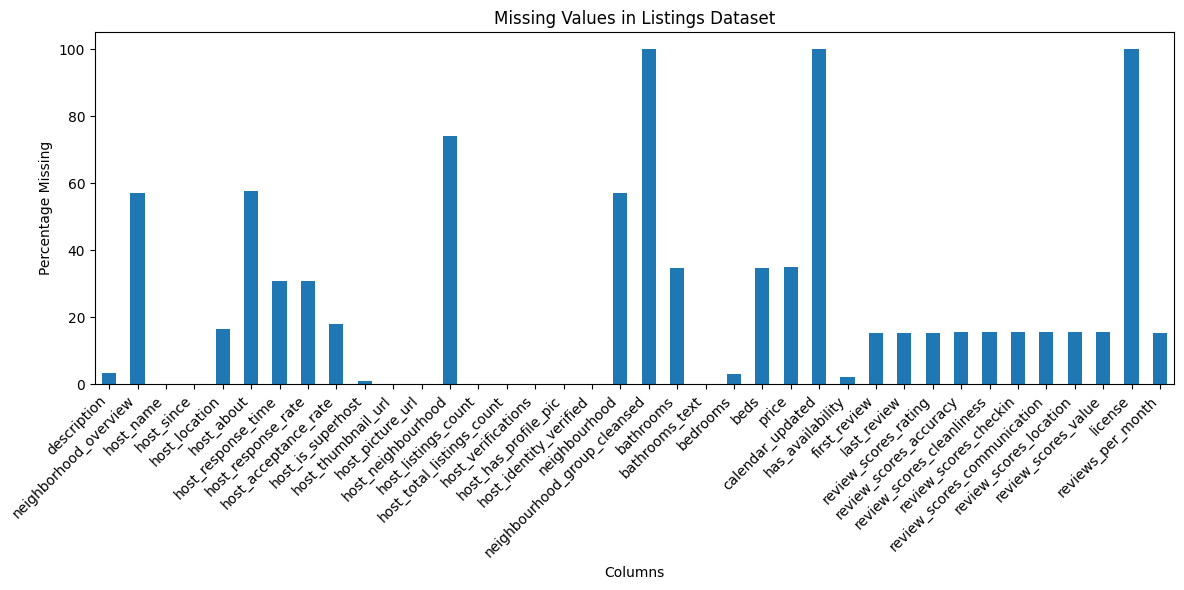

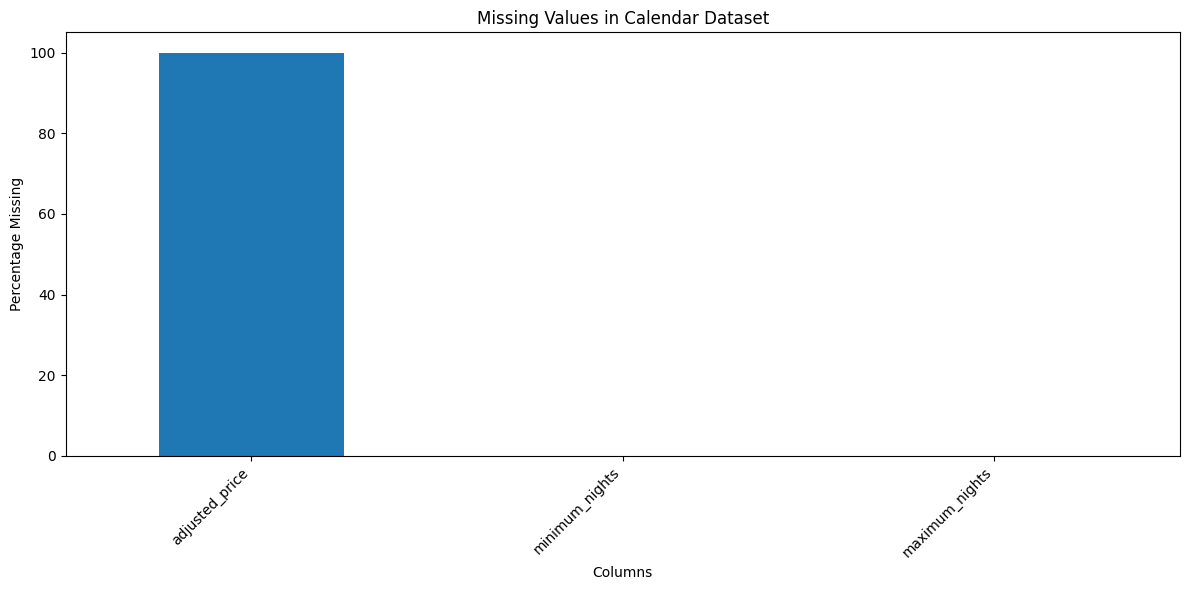

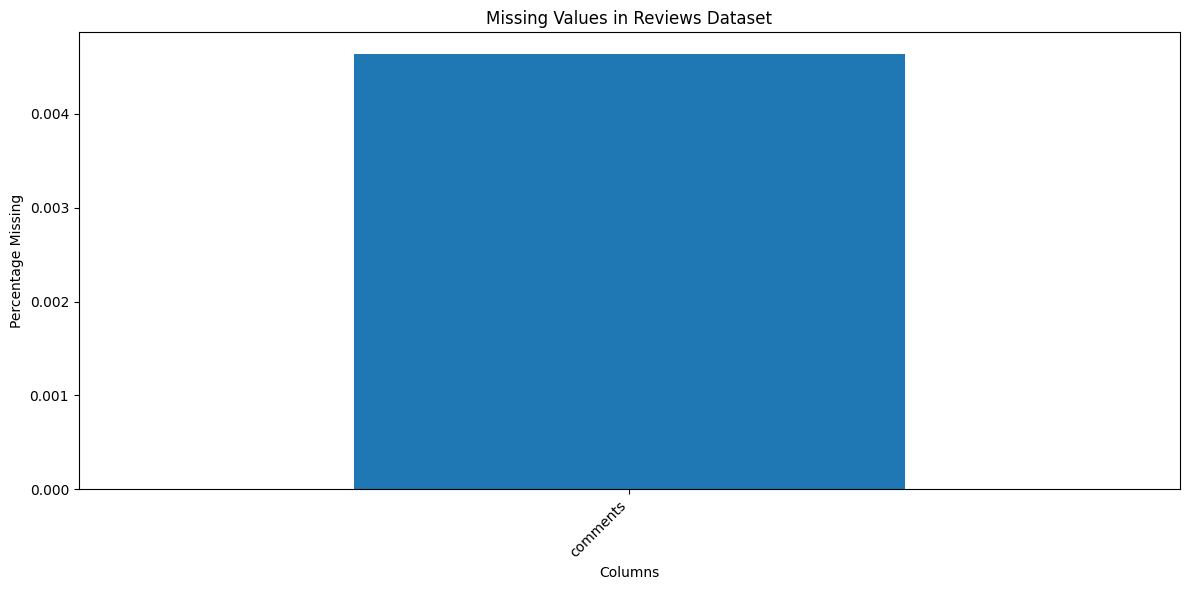

In [26]:
# Basic visualizations for initial insights
def plot_missing_values(missing_info, title):
    plt.figure(figsize=(12, 6))
    missing_info[missing_info['Missing Values'] > 0]['Percentage'].plot(kind='bar')
    plt.title(f'Missing Values in {title} Dataset')
    plt.xlabel('Columns')
    plt.ylabel('Percentage Missing')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot missing values for each dataset
plot_missing_values(listings_missing, 'Listings')
plot_missing_values(calendar_missing, 'Calendar')
plot_missing_values(reviews_missing, 'Reviews')

In [27]:
# Get columns with less than 3 unique values
def few_unique(df, threshold=3):
    """Returns and prints columns with less than threshold unique values."""
    cols = [col for col in df.columns if df[col].nunique() < threshold]
    print(f"Columns with less than {threshold} unique values:")
    for col in cols:
        print(f"{col}: {df[col].nunique()}")
    return cols

unique_cols = few_unique(lis_df)

Columns with less than 3 unique values:
scrape_id: 1
last_scraped: 2
source: 2
host_is_superhost: 2
host_has_profile_pic: 2
host_identity_verified: 2
neighbourhood_group_cleansed: 0
calendar_updated: 0
has_availability: 2
calendar_last_scraped: 2
license: 0
instant_bookable: 2
